In [1]:
import sys
import re
import os
import pandas as pd
import numpy as np
sys.path.append("../automaterialsdata/")

In [2]:
from property_comparison import OPV_PROPERTIES, EXAM_TYPE, compare_properties

In [3]:
def isfloat(s):
    try:
        return bool(re.match(u'^[−‐]?\d+(\.\d*)?',s))
    except:
        return False

def tofloat(s):
    return float(re.match(u'^[−‐]?\d+(\.\d*)?', s).group(0).replace('−', '').replace('‐', ''))
    
def count_valid_properties(data_list):
    return np.array([ int(isfloat(i)) for i in data_list])

In [6]:
# as VOC, JSC, FF, PCE
all_properties = pd.read_csv('../data/RSC_HTML_Table_Extractor_Reuslts.csv',encoding='utf-8')
all_properties = pd.concat([all_properties, 
                            pd.read_csv('../data/Wiley_HTML_Table_Extractor_Reuslts.csv',encoding='utf-8')],
                           sort=False, ignore_index=True)                            
all_properties = pd.concat([all_properties, 
                            pd.read_csv('../data/Elsevier_XMLs_Table_Extractor_Reuslts.csv',encoding='utf-8')],
                           sort=False, ignore_index=True)

acc_counts = np.zeros(4)
all_four_properties_df = pd.DataFrame([], columns = all_properties.columns)
all_four_properties_subset = {}
paper_ids  = set()

for i in range(all_properties.shape[0]):
    record = all_properties.iloc[i, :].tolist()
    

    paper_ids.add(record[0].split('_')[0])
#     if (not any([isfloat(x) for x in record[4:]])): continue
            
#     if (type(record[1]) == str):
#         valuekey = record[0].split('_')[0] + record[1]
#     else:
#         valuekey = record[0]
    
    valuekey = record[0]
    if valuekey not in all_four_properties_subset.keys():
        all_four_properties_subset[valuekey] = record.copy()
    elif not isfloat(record[4]): continue
    elif not isfloat(all_four_properties_subset[valuekey][4]):
        all_four_properties_subset[valuekey] = record.copy()
    elif tofloat(record[4]) > tofloat(all_four_properties_subset[valuekey][4]):
        all_four_properties_subset[valuekey] = record.copy()

counts = np.zeros(4)
for r in all_four_properties_subset.values():
    counts += count_valid_properties(r[4:])
    #all_four_properties_subset.append(all([isfloat(x) for x in record[4:]]))

temp_df = pd.DataFrame(all_four_properties_subset.values(), columns = all_properties.columns)
all_four_properties_df = pd.concat([all_four_properties_df,temp_df], sort=False,ignore_index=True)
    
    
counts

array([1306., 1277., 1361., 1252.])

In [7]:
all_four_properties_df.shape

(1518, 8)

In [8]:
len(paper_ids)

216

In [9]:
data_path = '../data/CDE_XML_HTML_Results.csv'
data = pd.read_csv(data_path, encoding="UTF-8")

saeki_path = '../../Saekis_manual_dataset.csv'
saeki_cols = ['ID No.','Nickname', 'Ref. No',  'Voc', 'Jsc', 'FF', 'PCE_max']
saeki = pd.read_csv(saeki_path, encoding="UTF-8", usecols=saeki_cols)

In [10]:
subset_ids = [x[1:] in paper_ids for x in saeki['Ref. No']]
saeki_subset = saeki.loc[subset_ids]

In [11]:
saeki_subset.shape

(482, 7)

In [12]:
saeki_subset.iloc[0, 3:]

PCE_max     7.64
Voc         0.79
Jsc        14.02
FF         0.691
Name: 16, dtype: object

In [13]:
all_four_properties_df.iloc[0, [7, 4, 5, 6]] 

PCE (%)           4.27/4.12
V OC (V)               0.76
J SC (mA/cm-2)         9.77
FF (%)                 0.58
Name: 0, dtype: object

In [14]:
saeki_cols = ['PCE_max', 'Voc', 'Jsc', 'FF']
errors = [0.2, 0.02, 0.5, 0.01]
total_miss = 0
total_miss_individual = np.zeros(4)

for paper_id in paper_ids:
    print("Compare Results from ", paper_id)
    tmp_result = [paper_id]
    
    saeki_result = saeki[saeki['Ref. No'] == 'S'+ str(paper_id)]
    
    te_subset = np.array([ x.split('_')[0] == paper_id for x in all_four_properties_df['Unnamed: 0'] ])
    
    te_result = all_four_properties_df[te_subset]
    
    miss_count = saeki_result.shape[0]
    miss_count_2 = np.ones(4) * miss_count
    count_not_full_but_individual_all_match = 0
    
    #print(saeki_result)
    #print(te_result)
    for i in range(saeki_result.shape[0]):
        
        sr = np.array(saeki_result.iloc[i, 3:].to_list())
        full_match = False
        partial_matched_sets = [set() for _ in range(4)]
        
        # find full match
        for j in range(te_result.shape[0]):
            te_raw = te_result.iloc[j, [7, 4, 5, 6]].to_list()
            if all([isfloat(x) for x in te_raw]):

                te = np.array([tofloat(x) for x in te_raw])

                if te[1] > 100: te[1] /= 1000 #VOC
                if te[3]  > 1: te[3] /= 100    #FF
                #if te[0]  > 1: te[0] /= 100  #PCE   
                #print(te, sr)
                if all([abs(sr[k] - te[k]) <= errors[k] for k in range(4)]):
                    miss_count -= 1
                    miss_count_2 -=1
                    full_match = True
                    break
                
        if (not full_match):
            sr_found = np.array([False, False, False, False])
            #match individual ones
            for j in range(te_result.shape[0]):
                
                if all(sr_found): 
                    count_not_full_but_individual_all_match += 1
                    break
                te_raw = te_result.iloc[j, [7, 4, 5, 6]].to_list()
                
                for k in range(4):
                    if (j in partial_matched_sets[k]): continue
                    
                    if not sr_found[k] and isfloat(te_raw[k]):
                        te = tofloat(te_raw[k])
                        
                        if k == 1 and te > 100: te /= 1000 #VOC
                        if k == 3 and te > 1: te /= 100    #FF
                        
                        if abs(sr[k] - te) <= errors[k]:
                            sr_found[k] = True
                            miss_count_2[k] -= 1
                            partial_matched_sets[k].add(j)

    total_miss += miss_count
    total_miss_individual += miss_count_2
    if miss_count > 0 : print("- Miss Count:", miss_count)

Compare Results from  128
Compare Results from  302
Compare Results from  221
Compare Results from  440
- Miss Count: 2
Compare Results from  261
Compare Results from  281
Compare Results from  73
Compare Results from  247
Compare Results from  197
- Miss Count: 3
Compare Results from  278
Compare Results from  203
Compare Results from  209
Compare Results from  60
Compare Results from  155
Compare Results from  384
Compare Results from  279
- Miss Count: 5
Compare Results from  91
Compare Results from  244
Compare Results from  94
Compare Results from  331
Compare Results from  323
Compare Results from  498
Compare Results from  235
Compare Results from  427
Compare Results from  471
Compare Results from  399
Compare Results from  486
Compare Results from  320
Compare Results from  361
Compare Results from  214
Compare Results from  291
Compare Results from  274
Compare Results from  462
Compare Results from  472
Compare Results from  44
Compare Results from  391
Compare Results from 

In [15]:
total_miss

66

In [16]:
total_miss_individual

array([52., 12., 22., 17.])

In [17]:
count_not_full_but_individual_all_match

0

In [72]:
paper_id = '169'

saeki_result = saeki[saeki['Ref. No'] == 'S'+ str(paper_id)]
te_subset = np.array([ x.split('_')[0] == paper_id for x in all_four_properties_df['Unnamed: 0'] ])
te_result = all_four_properties_df[te_subset]
te_subset = np.array([ x.split('_')[0] == paper_id for x in all_properties['Unnamed: 0'] ])
te_result2 = all_properties[te_subset]

In [73]:
saeki_result

,ID No.,Nickname,Ref. No,PCE_max,Voc,Jsc,FF
410,411,PBDT(O)-T1,S169,4.01,0.83,9.6,0.495
411,412,PBDT(S)-T1,S169,7.48,0.90,12.3,0.711
412,413,PBDT(Se)-T1,S169,8.52,0.92,13.1,0.721


In [74]:
te_result

,Unnamed: 0,0,1,2,V OC (V),J SC (mA/cm-2),FF (%),PCE (%)
136,169_6_0,PBDT(O)-T1:PC70BM,NaN,NaN,0.83 ± 0.01,9.6 ± 0.2 (9.1),49.5 ± 0.6,4.0 ± 0.1
137,169_6_1,PBDT(S)-T1:PC70BM,NaN,NaN,0.89 ± 0.01,12.2 ± 0.1 (12.1),67.7 ± 0.4,7.3 ± 0.1
138,169_6_2,PBDT(Se)-T1:PC70BM,NaN,NaN,0.91 ± 0.01,13.0 ± 0.1 (12.6),71.7 ± 0.4,8.4 ± 0.1


In [75]:
counts

array([947., 926., 957., 926.])

In [76]:
saeki_subset.shape

(482, 7)

In [77]:
total_miss_individual

array([106.,  47.,  81.,  85.])

In [78]:
TP = 482 - total_miss_individual
TP

array([376., 435., 401., 397.])

In [79]:
FN = counts - TP
FN

array([571., 491., 556., 529.])

In [18]:
counts, total_miss_individual

(array([1306., 1277., 1361., 1252.]), array([52., 12., 22., 17.]))

In [19]:
TP = 482 - total_miss_individual
TP

array([430., 470., 460., 465.])

In [20]:
FN = counts - TP
FN

array([876., 807., 901., 787.])

In [21]:
print(OPV_PROPERTIES)

['PCE', 'VOC', 'JSC', 'FF']


In [22]:
print(EXAM_TYPE)

['value_only_TP', 'value_only_FN', 'value_only_Miss', 'TP', 'FP', 'FN', 'Miss']


In [25]:
sum_results = [TP, FN, total_miss_individual]
sum_df = pd.DataFrame(data=[], columns=['Property', 'Exam_type', 'Count'])

for i in range(4):
    p = OPV_PROPERTIES[i]
    for j in range(3):
        eT = EXAM_TYPE[j]
        col = '_'.join([p,eT])
        tmp_result = [p, eT, sum_results[j][i]]
        temp_df = pd.DataFrame(data=[tmp_result], columns=['Property', 'Exam_type', 'Count'])
        sum_df = pd.concat([sum_df, temp_df], ignore_index=True)

sum_df

,Property,Exam_type,Count
0,PCE,value_only_TP,430.0
1,PCE,value_only_FN,876.0
2,PCE,value_only_Miss,52.0
3,VOC,value_only_TP,470.0
4,VOC,value_only_FN,807.0
5,VOC,value_only_Miss,12.0
6,JSC,value_only_TP,460.0
7,JSC,value_only_FN,901.0
8,JSC,value_only_Miss,22.0
9,FF,value_only_TP,465.0


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

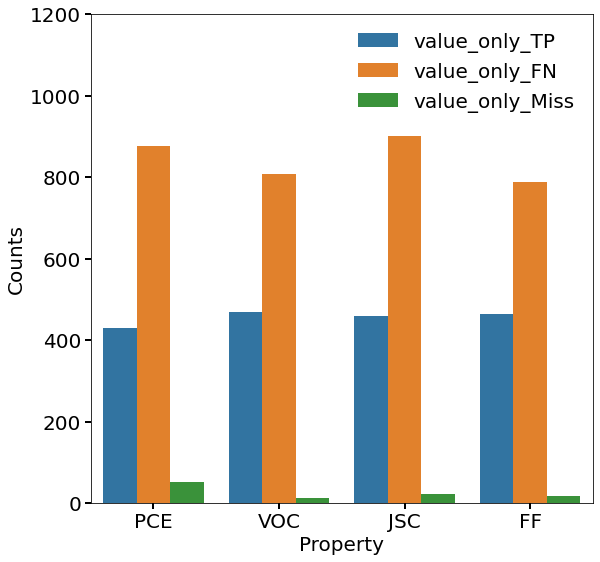

In [33]:
fig,ax = plt.subplots(figsize=(9,9))

sns.barplot(x="Property", y="Count", hue="Exam_type", data=sum_df, ax=ax)

ax.set_xlabel('Property', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
ax.tick_params(direction='out', length=6, width=2, labelsize=20)
ax.legend(frameon=False, fontsize=20)

ax.set_ylim([0, 1200])

fig.savefig('./tableextractor_result.png', bbox_inches='tight') 